In this notebook, we will try to build a very simple model to predict the outcome of tennis matched.  This is an ELO model.  Specifically, we will model

$$p(y_1) = \sigma(\beta_1 - \beta_2)$$, where $$\beta_1$$ and $$\beta_2$$ are coefficients for players 1 and 2 respectively

In [1]:
from models.logit.base import get_match_result_data

df, player_mapping, inverse_player_mapping = get_match_result_data()

In [2]:
df.shape

(50784, 62)

50k matches to work with

#### Set up training data

First, we'll just try training on everything in this time period and see what happens.  Later, we will split into train and test sets and figure out appropriate discounting, etc.

In [3]:
from models.logit.base import get_X_y

X, y = get_X_y(df, player_mapping, include_ranks=False)
assert ((X > 0).sum(axis=1) == 1).all()
assert ((X < 0).sum(axis=1) == 1).all()

#### Create Logistic Regression with NonZero Prior

I'll start with a zero prior and go from there...

In [4]:
import pandas as pd

def describe_result(coefs, inverse_player_map):
    coef_df = pd.DataFrame(list(enumerate(coefs[:len(inverse_player_map)])),
        columns=['player_idx', 'coef']
    )
    coef_df['player_name'] = coef_df['player_idx'].map(lambda x: inverse_player_map[x])
    return coef_df.sort_values(by='coef', ascending=False)

In [5]:
from ml.prior_logit import NonZeroLogit

nzl = NonZeroLogit(lmbda=1.)
nzl.fit(X, y)
describe_result(nzl.beta, inverse_player_mapping).head()

,player_idx,coef,player_name
2,2,3.208268,Djokovic N.
766,766,3.101896,Federer R.
51,51,3.069322,Nadal R.
271,271,2.739206,Murray A.
1198,1198,2.350040,Roddick A.


In [6]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(fit_intercept=False)
logit.fit(X, y)
describe_result(logit.coef_[0], inverse_player_mapping).head()

,player_idx,coef,player_name
2,2,3.208592,Djokovic N.
766,766,3.102251,Federer R.
51,51,3.068686,Nadal R.
271,271,2.739398,Murray A.
1198,1198,2.350218,Roddick A.


#### Tune Time-Decay and Regularization

There is an argument that we should not be regularizing towards 0.  Players that appear infrequently are probably wors -- they qualify for fewer tournaments and progress to later rounds of tournaments less often.  For now however, we will continue to regularize towards 0.  Here, we investigate the following:

* What time decay weight is most predictive?
* How much regularization should we use?

In [7]:
# Start by updating model every New Year's Day
BURN_IN_DATE = 2010
END_DATE = 2019
TIME_BREAKS = ['%d-01-01' % year for year in range(BURN_IN_DATE, END_DATE)]
TIME_BREAKS = map(pd.to_datetime, TIME_BREAKS)
TIME_BREAKS

[Timestamp('2010-01-01 00:00:00'),
 Timestamp('2011-01-01 00:00:00'),
 Timestamp('2012-01-01 00:00:00'),
 Timestamp('2013-01-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00')]

In [8]:
import numpy as np

def fit_model(train_X, train_y, test_X, test_y, weights=None, lmbda=1.0, prior=0.):
    print 'Fitting model...'
    logit = NonZeroLogit(lmbda=lmbda, prior=prior)
    if weights is None:
        weights = np.ones(train_X.shape[0])
    logit.fit(train_X, train_y, sample_weight=weights)
    print 'Predicting probs...'
    preds = logit.predict_proba(test_X)[:, 1] 
    print 'Predicting classes...'
    class_preds = logit.predict(test_X)
    return logit, preds, class_preds

Let's confirm that get_weights is doing what it's supposed to be doing:

In [9]:
from models.logit.base import _get_weights

weights = _get_weights(df['date'].max(), df, 365.)

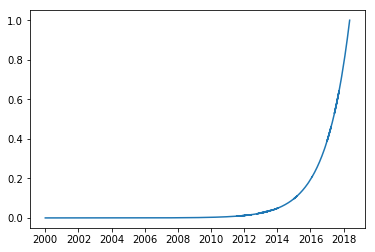

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(df['date'], weights)

Looks like the weighting is doing roughly what it is supposed to...

In [11]:
from sklearn.metrics import roc_auc_score

def eval_model(lmbda=1.0, halflife=None, prior=0., max_rank=None, include_ranks=False):
    if max_rank is not None:
        _df = df[
            (df['wrank'] < max_rank) &
            (df['lrank'] < max_rank)
        ].copy()
    else:
        _df = df.copy()
        
    mods = []
    out = []
    _df['__weight__'] = 10000 *_get_weights(
        _df['date'].max(),
        _df,
        halflife
    )
    for i in range(len(TIME_BREAKS)):
        cur_break = TIME_BREAKS[i]
        if i + 1 == len(TIME_BREAKS):
            next_break = pd.to_datetime('2099-12-31')
        else:
            next_break = TIME_BREAKS[i + 1]
        print cur_break, next_break
        train_df = _df[_df['date'] < cur_break]
        test_df = _df[
            (_df['date'] >= cur_break) &
            (_df['date'] < next_break)
        ]
        train_X, train_y = get_X_y(train_df, player_mapping, include_ranks=include_ranks)
        test_X, test_y = get_X_y(test_df, player_mapping, include_ranks=include_ranks)
        mod, preds, class_preds = fit_model(
            train_X,
            train_y,
            test_X,
            test_y,
            lmbda=lmbda,
            weights=train_df['__weight__']
        )
        mods.append(mod)
        out.extend(zip(test_df['match_id'].tolist(), preds.tolist(), class_preds.tolist()))
    out_df = pd.DataFrame(out, columns=['match_id', 'pred', 'class_pred'])
    final_df = pd.merge(_df, out_df, on='match_id')

    if max_rank is not None:
        rel = final_df[
            (final_df['lrank'] < max_rank) &
            (final_df['wrank'] < max_rank)
        ]
    else:
        rel = final_df

    auc = roc_auc_score(rel['y'], rel['pred'])
    accuracy = (rel['y'] == rel['class_pred']).mean() 
    print auc, accuracy
    return mods, out, final_df, auc, accuracy 

In [12]:
N_ATTEMPTS = 20
lmbdas = np.power(10., np.random.uniform(-3, 3, size=N_ATTEMPTS))
hls = np.random.uniform(100, 4 * 365, size=N_ATTEMPTS)
priors = np.random.uniform(-5., 0., size=N_ATTEMPTS)
out = []
for lmbda, hl, prior in zip(lmbdas, hls, priors):
    print lmbda, hl, prior
    _, _, _, auc, accuracy = eval_model(lmbda=lmbda, halflife=hl, prior=prior)
    out.append((lmbda, hl, prior, auc, accuracy))

0.0657118642699 1433.05702566 -2.0687553733
2010-01-01 00:00:00 2011-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2011-01-01 00:00:00 2012-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2012-01-01 00:00:00 2013-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2013-01-01 00:00:00 2014-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2014-01-01 00:00:00 2015-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2015-01-01 00:00:00 2016-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2016-01-01 00:00:00 2017-01-01 00:00:00
Fitting model...


KeyboardInterrupt: 

In [ ]:
tuning_df = pd.DataFrame(
    out,
    columns=[
        'lambda',
        'halflife',
        'prior',
        'auc',
        'accuracy'
    ]
)

In [ ]:
tuning_df.sort('auc', ascending=False)

In [13]:
mods, _, final_df, _, _ = eval_model(lmbda=100.0, halflife=365, prior=-2.0, max_rank=None, include_ranks=False)

2010-01-01 00:00:00 2011-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2011-01-01 00:00:00 2012-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2012-01-01 00:00:00 2013-01-01 00:00:00
Fitting model...


/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ml/prior_logit.py:20: RuntimeWarning: divide by zero encountered in log
  (y * np.log(y_hat) + (1. - y) * np.log(1. - y_hat))
/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ml/prior_logit.py:20: RuntimeWarning: invalid value encountered in multiply
  (y * np.log(y_hat) + (1. - y) * np.log(1. - y_hat))


Predicting probs...
Predicting classes...
2013-01-01 00:00:00 2014-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2014-01-01 00:00:00 2015-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2015-01-01 00:00:00 2016-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2016-01-01 00:00:00 2017-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2017-01-01 00:00:00 2018-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2018-01-01 00:00:00 2099-12-31 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
0.726774783695 0.665690866511


In [14]:
final_df[['tournament', 'winner', 'loser', 'winner_idx', 'loser_idx', 'p1_idx', 'p2_idx', 'pred', 'y']].tail(20)

,tournament,winner,loser,winner_idx,loser_idx,p1_idx,p2_idx,pred,y
22184,Mutua Madrid Open,Schwartzman D.,Lopez F.,839,116,839,116,0.492711,1
22185,Mutua Madrid Open,Mayer L.,Verdasco F.,765,936,765,936,0.428261,1
22186,Mutua Madrid Open,Coric B.,Struff J.L.,829,843,829,843,0.546277,1
22187,Mutua Madrid Open,Thiem D.,Delbonis F.,1151,318,318,1151,0.248272,0
22188,Mutua Madrid Open,Zverev A.,Donskoy E.,1390,1282,1282,1390,0.064980,0
22189,Mutua Madrid Open,Edmund K.,Goffin D.,1256,1313,1256,1313,0.304674,1
22190,Mutua Madrid Open,Shapovalov D.,Raonic M.,725,1168,1168,725,0.737971,0
22191,Mutua Madrid Open,Anderson K.,Kohlschreiber P.,888,191,191,888,0.487809,0
22192,Mutua Madrid Open,Lajovic D.,Del Potro J.M.,767,713,713,767,0.889980,0
22193,Mutua Madrid Open,Thiem D.,Coric B.,1151,829,1151,829,0.712128,1


In [15]:
for tb, mod in zip(TIME_BREAKS, mods):
    print '\n' + str(tb)
    print '\n---------------------------'
    print describe_result(mod.beta, inverse_player_mapping).head(20)


2010-01-01 00:00:00

---------------------------
      player_idx      coef     player_name
766          766  2.095361      Federer R.
51            51  1.995969        Nadal R.
2              2  1.879716     Djokovic N.
271          271  1.801630       Murray A.
1198        1198  1.449837      Roddick A.
713          713  1.409153  Del Potro J.M.
22            22  1.332267    Davydenko N.
287          287  1.105697    Soderling R.
1171        1171  1.102580     Tsonga J.W.
916          916  1.070882     Gonzalez F.
1241        1241  1.031981   Nalbandian D.
936          936  0.974689     Verdasco F.
347          347  0.955953     Stepanek R.
1302        1302  0.933144      Monfils G.
1023        1023  0.922328       Hewitt L.
854          854  0.912887       Ferrer D.
481          481  0.910422        Cilic M.
724          724  0.883167        Simon G.
32            32  0.843853      Robredo T.
36            36  0.813421         Haas T.

2011-01-01 00:00:00

-------------------------

How are we calibrated?

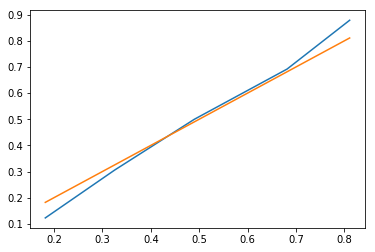

In [16]:
from sklearn.calibration import calibration_curve

_x, _y = calibration_curve(final_df['y'], final_df['pred'])
plt.plot(_x, _y)
plt.plot(_x, _x)

Pessimistic on the lower end, optimistic on the higher end...

In [17]:
def investigate_player(player_name):
    return df[
        df['winner'].map(lambda x: player_name in x) |
        df['loser'].map(lambda x: player_name in x)
    ][[
        'date',
        'winner',
        'loser',
    ]].tail(30)

In [18]:
investigate_player('Roddick')

,date,winner,loser
512,2012-02-23,Malisse X.,Roddick A.
575,2012-02-29,Roddick A.,Petzschner P.
583,2012-03-02,Roddick A.,Istomin D.
587,2012-03-03,Anderson K.,Roddick A.
658,2012-03-10,Roddick A.,Kubot L.
692,2012-03-13,Berdych T.,Roddick A.
770,2012-03-24,Roddick A.,Muller G.
795,2012-03-27,Roddick A.,Federer R.
802,2012-03-27,Monaco J.,Roddick A.
1234,2012-05-27,Mahut N.,Roddick A.


#### Naive Model that only uses rank to make class predictions

In [ ]:
df['rank_pred'] = (df['p1_rank'] < df['p2_rank'])
rel_df = df[
    (df['date'] > TIME_BREAKS[0]) &
    df['p1_rank'].notnull() &
    df['p2_rank'].notnull()
]
(rel_df['rank_pred'] == rel_df['y']).mean()

66.6% from using rank alone...but this_updates_constantly and this only looks at matches where both players have rankings...

In [ ]:
# Get year end rankings
rank_df = df.copy()
rank_df['year'] = rank_df['date'].map(lambda x: x.year)
_winner_rank_df = rank_df.groupby(['year', 'winner']).apply(
    lambda x: x[['year', 'winner', 'date', 'wrank']].iloc[-1]
).reset_index(drop=True)
_winner_rank_df.rename(columns={'winner': 'player'}, inplace=True)
_winner_rank_df.rename(columns={'wrank': 'ye_rank'}, inplace=True)

_loser_rank_df = rank_df.groupby(['year', 'loser']).apply(
    lambda x: x[['year', 'loser', 'date', 'lrank']].iloc[-1]
).reset_index(drop=True)
_loser_rank_df.rename(columns={'loser': 'player'}, inplace=True)
_loser_rank_df.rename(columns={'lrank': 'ye_rank'}, inplace=True)

tot_rank_df = pd.concat([_winner_rank_df, _loser_rank_df])
tot_rank_df.sort('date', ascending=True, inplace=True)
year_end_rankings = tot_rank_df.drop_duplicates(['player', 'year'], take_last=True)

In [ ]:
_for_merge = year_end_rankings.copy()
_for_merge['year'] += 1  # Want to match year end rankings for 2000 with matches in 2001

In [ ]:
rank_df = pd.merge(
    rank_df,
    _for_merge,
    left_on=['winner', 'year'],
    right_on=['player', 'year']
)
rank_df.rename(columns={'ye_rank': 'winner_ye_rank'}, inplace=True)

rank_df = pd.merge(
    rank_df,
    _for_merge,
    left_on=['loser', 'year'],
    right_on=['player', 'year']
)
rank_df.rename(columns={'ye_rank': 'loser_ye_rank'}, inplace=True)

In [ ]:
rel_df = rank_df[
    (rank_df['date'] > TIME_BREAKS[0]) &
    rank_df['winner_ye_rank'].notnull() &
    rank_df['loser_ye_rank'].notnull()
]
(rank_df['winner_ye_rank'] < rank_df['loser_ye_rank']).mean()

Only 64% accuracy when we use year-end rankings so apples-to-apples time comparison and can't update rank all the time